In [1]:
import numpy as np
from sklearn.svm import LinearSVC, SVC
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, validation_curve, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
from itertools import permutations, product
import warnings
from tqdm.notebook import tqdm
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 7]
from collections import namedtuple
from datetime import datetime
plt.style.use('ggplot')

# Backprop baseline

## Grid search

In [2]:
f = 16
pen_layers = [
    (f, f, f),
    (f, f//2, f//2),
    (f, f//2, f//4),
    (f, f),
    (f, f//2),
    (f//2, f//4)
]
all_params = list(product(pen_layers, [0.0001, 0.001, 0.01], ['relu', 'tanh', 'sigmoid'], [True]))

In [6]:
data = fetch_openml(data_id=32)
X = data.data
y = data.target.reshape((-1,1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, shuffle=True)
oh = OneHotEncoder()

y_train = oh.fit_transform(y_train).todense()
y_test = oh.transform(y_test).todense()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# best params in SK learn
param = {'nn__activation': 'relu', 'nn__alpha': 0.1, 'nn__hidden_layer_sizes': (16, 16, 16), 'nn__learning_rate_init': 0.001}
# val_train_scores, val_test_scores = validation_curve(pipe, X_train, y_train, 
#                                          param_name=param, 
#                                          param_range=self.gridParams[param])

# nn = mlrose.NeuralNetwork(HIDDEN_LAYER_SHAPE, activation='sigmoid', \
#                          algorithm='gradient_descent', max_iters = 1000, \
#                          bias = False, is_classifier = True, learning_rate = 0.001,
#                          early_stopping = True, max_attempts = 100, random_state = 2, clip_max=5)


In [5]:
best_score = 0
best_params = None
scored_params = []

for hidden, lr, activation, bias in tqdm(all_params, desc='parameters'):
    nn = mlrose.NeuralNetwork(list(hidden), activation=activation, \
                         algorithm='gradient_descent', max_iters = 1000, \
                         bias = bias, is_classifier = True, learning_rate = lr,
                         early_stopping = True, max_attempts = 100, random_state = 1, clip_max=10)
    nn.fit(X_train, y_train)
    pred = nn.predict(X_test) 
    score = accuracy_score(y_test, pred)
    p = (hidden, lr, activation, bias)
    scored_params.append((score,p))

KeyboardInterrupt: 

In [7]:
gd_nn = nn
scored_params = list(sorted(scored_params, key = lambda x: -x[0]))
print('\n'.join([str(x) for x in scored_params[:5]]))
gd_scored_params = scored_params

## GD Curves

In [9]:
hidden, lr, activation, bias = gd_scored_params[0] # [(16,16), 0.001, 'relu', True]

def create_gd_nn(p, random_state=1):
    hidden, lr, activation, bias = p
    nn = mlrose.NeuralNetwork(list(hidden), activation=activation, \
                             algorithm='gradient_descent', max_iters = 1000, \
                             bias = bias, is_classifier = True, learning_rate = lr,
                             early_stopping = True, max_attempts = 100, random_state = random_state, clip_max=10, curve=True)
    return nn

### Time to converge 

ValueError: multilabel-indicator is not supported

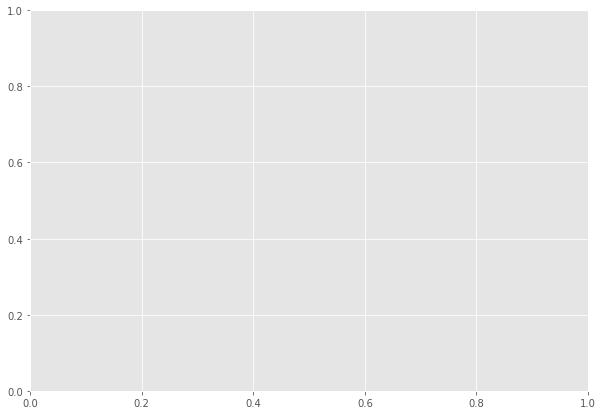

In [48]:
gd_best_params = gd_scored_params[0]
avg_time_ms = 0
avg_acc = 0
folds = 3 # TODO change for other tests
fitness_curve = None
best_score = float('-inf');

for k in range(folds):
    nn = create_gd_nn(gd_best_params, k+1)
    start = datetime.utcnow()
    nn.fit(X_train, y_train)
    end = datetime.utcnow()
    elapsed = end - start
    avg_time_ms += elapsed.total_seconds() * 100
    
    pred = nn.predict(X_test)     
    acc = accuracy_score(y_test, pred)
    avg_acc += acc
    
    if(acc > best_score):
        best_score = acc
        fitness_curve = nn.fitness_curve
    
    if k == folds - 1:
        fig, ax = plt.subplots()
        disp = plot_confusion_matrix(nn, X_test, y_test, normalize='false', values_format='.2f', cmap='GnBu', ax=ax)
        disp.ax_.set_title(f'Pen Digits: Gradient Descent Confusion matrix')
        
avg_time_ms /= folds
avg_acc /= folds
fitness_curve /= folds


plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Pen Digits: Gradient Descent Fitness curve')
ax.plot(np.arange(len(fitness_curve)), fitness_curve)


# RHC 

In [42]:
rhc_params = namedtuple('RhcParams', ['layer', 'activation', 'bias', 'learning_rate', 'restarts'])
best_pen_layer = [(16, 16)]
all_params = [rhc_params(*x) for x in list(product(best_pen_layer, ['relu'], [True],
                         [1.0, 0.1, 0.001, 0.0001, 0.0001], [10, 100, 1000, 3000]))]

def create_rhc_NN(p, random_state=1):
    hidden = p.layer
    activation = p.activation
    bias = p.bias
    lr = p.learning_rate
    restarts = p.restarts
    return mlrose.NeuralNetwork(list(hidden), activation=activation, \
                         algorithm='gradient_descent', max_iters = 10*restarts, \
                         bias = bias, is_classifier = True, learning_rate = lr, restarts = restarts,
                         early_stopping = True, max_attempts = 100, random_state = random_state, clip_max=10)

In [44]:
scored_params = []
for p in tqdm(all_params, desc='parameters'):
    print(p)
    nn = createNN(p, 1)
    nn.fit(X_train, y_train)
    pred = nn.predict(X_test) 
    score = accuracy_score(y_test, pred)
    p = (hidden, lr, activation, bias)
    scored_params.append((score,p))

RhcParams(layer=(16, 16), activation='relu', bias=True, learning_rate=1.0, restarts=10)
RhcParams(layer=(16, 16), activation='relu', bias=True, learning_rate=1.0, restarts=100)
RhcParams(layer=(16, 16), activation='relu', bias=True, learning_rate=1.0, restarts=1000)
RhcParams(layer=(16, 16), activation='relu', bias=True, learning_rate=1.0, restarts=3000)
RhcParams(layer=(16, 16), activation='relu', bias=True, learning_rate=0.1, restarts=10)
RhcParams(layer=(16, 16), activation='relu', bias=True, learning_rate=0.1, restarts=100)
RhcParams(layer=(16, 16), activation='relu', bias=True, learning_rate=0.1, restarts=1000)
RhcParams(layer=(16, 16), activation='relu', bias=True, learning_rate=0.1, restarts=3000)
RhcParams(layer=(16, 16), activation='relu', bias=True, learning_rate=0.001, restarts=10)
RhcParams(layer=(16, 16), activation='relu', bias=True, learning_rate=0.001, restarts=100)
RhcParams(layer=(16, 16), activation='relu', bias=True, learning_rate=0.001, restarts=1000)
RhcParams(lay

KeyboardInterrupt: 

In [45]:
scored_params

[(0.10189228529839883, ((8, 4), 0.01, 'sigmoid', True)),
 (0.10189228529839883, ((8, 4), 0.01, 'sigmoid', True)),
 (0.10189228529839883, ((8, 4), 0.01, 'sigmoid', True)),
 (0.10189228529839883, ((8, 4), 0.01, 'sigmoid', True)),
 (0.10189228529839883, ((8, 4), 0.01, 'sigmoid', True)),
 (0.10189228529839883, ((8, 4), 0.01, 'sigmoid', True)),
 (0.10189228529839883, ((8, 4), 0.01, 'sigmoid', True)),
 (0.10189228529839883, ((8, 4), 0.01, 'sigmoid', True)),
 (0.10771470160116449, ((8, 4), 0.01, 'sigmoid', True)),
 (0.13355167394468703, ((8, 4), 0.01, 'sigmoid', True)),
 (0.13355167394468703, ((8, 4), 0.01, 'sigmoid', True)),
 (0.13355167394468703, ((8, 4), 0.01, 'sigmoid', True)),
 (0.9665211062590975, ((8, 4), 0.01, 'sigmoid', True)),
 (0.9890829694323144, ((8, 4), 0.01, 'sigmoid', True))]

In [59]:
nn.fit(X_train, y_train)

NeuralNetwork(bias=False, clip_max=5, early_stopping=True,
              hidden_nodes=[16, 16, 16], learning_rate=0.001, max_iters=1000)

In [66]:
pred = nn.predict(X_test) 
accuracy_score(y_test, pred)

IndexError: list index out of range

In [67]:
print(best_score)
print(best_params)

NameError: name 'best_score' is not defined

In [26]:
np.std(X_train, axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])